In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import graphviz

def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
    
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [2]:
df = pd.read_csv("train.csv")
df.drop("Unnamed: 0",axis=1,inplace=True)
df = df[df["days"] != -1]
df = df[df["height"] >= 26 ]
df = df[df["width"] >= 242 ]
df

,campaign_id,chain_id,start_date,end_date,format,device,height,width,iremoteid,days,start_day,end_day,shop,budget
0,8963,12,2019-07-21,2019-07-24,banner,DESKTOP,200.0,995.0,['31834'],5.0,7.0,3.0,0.0,3579.344177
1,11875,11,2020-09-01,2020-09-05,butterfly,DESKTOP,486.0,278.0,['C75204'],6.0,2.0,6.0,0.0,5251.781250
2,25899,11,2020-10-29,2020-11-24,butterfly,DESKTOP,488.0,265.0,['CB9645'],28.0,4.0,2.0,0.0,9814.411865
3,25458,10,2020-12-09,2020-12-15,banner,DESKTOP,150.0,1200.0,['C111392'],8.0,3.0,2.0,0.0,11428.571429
4,35293,12,2019-11-14,2019-12-26,banner,DESKTOP,200.0,995.0,['34341'],44.0,4.0,4.0,0.0,9328.322937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,33169,12,2019-07-03,2019-07-21,banner,DESKTOP,200.0,995.0,['31150'],20.0,3.0,7.0,0.0,10250.965576
6316,306,11,2020-04-23,2020-05-18,butterfly,DESKTOP,488.0,270.0,"['CB7692', 'CB7693']",27.0,4.0,1.0,0.0,8835.427002
6317,32436,11,2020-11-09,2020-11-17,butterfly,DESKTOP,486.0,273.0,['C104835'],10.0,1.0,2.0,0.0,7412.225952
6318,12732,12,2021-04-27,2021-07-04,butterfly,DESKTOP,298.0,398.0,['C144616'],70.0,2.0,7.0,0.0,19275.559998


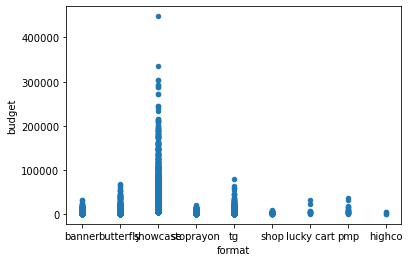

In [3]:
df.plot(kind="scatter",x="format",y="budget")

In [4]:
# load the dataset
y = df["budget"].astype('float64')
X = df.iloc[:,:len(df.columns)-1]
X["surface"] = X["width"]*X["height"]
X['campaign_id']=X['campaign_id'].astype('category').cat.codes
X['chain_id']=X['chain_id'].astype('category').cat.codes
X['iremoteid']=X['iremoteid'].astype('category').cat.codes
X['shop']=X['shop'].astype('category').cat.codes
X["end_day"]=X["end_day"].astype('category').cat.codes
X["start_day"]=X["start_day"].astype('category').cat.codes
X["format"]=X["format"].astype('category').cat.codes
X["device"]=X["device"].astype('category').cat.codes
X["start_year"] = X["start_date"].apply(lambda m: m.split("-")[0]).astype('category').cat.codes
X["end_year"] = X["end_date"].apply(lambda m: m.split("-")[0]).astype('category').cat.codes
X["start_month"] = X["start_date"].apply(lambda m: m.split("-")[1]).astype('category').cat.codes
X["end_month"] = X["end_date"].apply(lambda m: m.split("-")[1]).astype('category').cat.codes
X.drop(["start_date","end_date"],axis=1,inplace=True)
y

0        3579.344177
1        5251.781250
2        9814.411865
3       11428.571429
4        9328.322937
            ...     
6315    10250.965576
6316     8835.427002
6317     7412.225952
6318    19275.559998
6319    11899.551025
Name: budget, Length: 6313, dtype: float64

In [5]:
df.loc[df['format']=='butterfly']

,campaign_id,chain_id,start_date,end_date,format,device,height,width,iremoteid,days,start_day,end_day,shop,budget
1,11875,11,2020-09-01,2020-09-05,butterfly,DESKTOP,486.0,278.0,['C75204'],6.0,2.0,6.0,0.0,5251.781250
2,25899,11,2020-10-29,2020-11-24,butterfly,DESKTOP,488.0,265.0,['CB9645'],28.0,4.0,2.0,0.0,9814.411865
5,890,12,2020-11-02,2020-12-26,butterfly,DESKTOP,298.0,398.0,['C102891'],56.0,1.0,6.0,0.0,18229.278320
6,33145,7,2020-10-24,2020-11-23,butterfly,DESKTOP,394.0,576.0,['84006'],32.0,6.0,1.0,0.0,9777.499023
8,122,10,2020-08-24,2020-09-20,butterfly,DESKTOP,420.0,574.0,"['C77069', 'C77080']",29.0,1.0,7.0,0.0,9686.667297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6314,27906,12,2020-08-23,2020-08-23,butterfly,DESKTOP,298.0,398.0,['C68930'],2.0,7.0,7.0,0.0,1405.116211
6316,306,11,2020-04-23,2020-05-18,butterfly,DESKTOP,488.0,270.0,"['CB7692', 'CB7693']",27.0,4.0,1.0,0.0,8835.427002
6317,32436,11,2020-11-09,2020-11-17,butterfly,DESKTOP,486.0,273.0,['C104835'],10.0,1.0,2.0,0.0,7412.225952
6318,12732,12,2021-04-27,2021-07-04,butterfly,DESKTOP,298.0,398.0,['C144616'],70.0,2.0,7.0,0.0,19275.559998


Feature 0: 446.481512
Feature 1: 558.394027
Feature 2: 1027.126265
Feature 3: 1869.849236
Feature 4: 401.843372
Feature 5: 43.026106
Feature 6: 51.761607
Feature 7: 0.859071
Feature 8: 35.948372


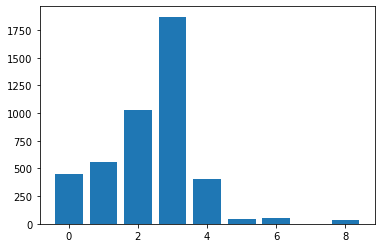

In [6]:
from sklearn.feature_selection import f_regression

def select_cat_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=f_regression, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_cat = X[["height","width","days","surface","format",'start_year','end_year','start_month','end_month']]

X_train, X_test, y_train, y_test = train_test_split(X_cat, y)

X_train_fs, X_test_fs, fs = select_cat_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Feature 0: 1053.863997
Feature 1: 1929.093362
Feature 2: 455.600258
Feature 3: 522.682800


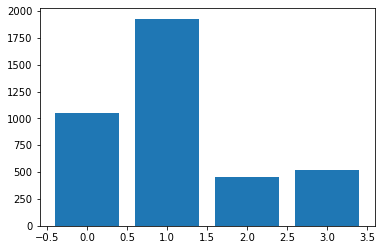

In [7]:
X_num = X[["days","surface","height","width"]]

X_train, X_test, y_train, y_test = train_test_split(X_num, y)

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

estimator = RandomForestRegressor(n_estimators=100,bootstrap=True,max_depth=30)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

selector.ranking_

array([ 4,  8, 11, 14, 10,  1,  2,  1,  3,  6, 13,  1, 12,  9,  7,  5])

In [9]:
X

,campaign_id,chain_id,format,device,height,width,iremoteid,days,start_day,end_day,shop,surface,start_year,end_year,start_month,end_month
0,1820,3,0,0,200.0,995.0,1322,5.0,6,2,0,199000.0,0,0,6,6
1,2277,2,1,0,486.0,278.0,5568,6.0,1,5,0,135108.0,1,1,8,8
2,4564,2,1,0,488.0,265.0,6087,28.0,3,1,0,129320.0,1,1,9,10
3,4497,1,0,0,150.0,1200.0,2214,8.0,2,1,0,180000.0,1,1,11,11
4,6022,3,0,0,200.0,995.0,1405,44.0,3,3,0,199000.0,0,0,10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,5690,3,0,0,200.0,995.0,1292,20.0,2,6,0,199000.0,0,0,6,6
6316,150,2,1,0,488.0,270.0,6064,27.0,3,0,0,131760.0,1,1,3,4
6317,5590,2,1,0,486.0,273.0,2092,10.0,0,1,0,132678.0,1,1,10,10
6318,2425,3,1,0,298.0,398.0,2992,70.0,1,6,0,118604.0,2,2,3,6


RMSE train: 1238.511140726872
RMSE test: 2565.324881619566


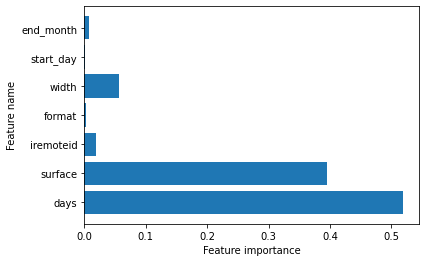

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

X_try=X[["days","surface",'iremoteid','format','width','start_day','end_month']]
X_train, X_test, y_train, y_test = train_test_split(X_try, y, train_size = 0.8 ,random_state = 0)

regr = GradientBoostingRegressor(n_estimators=200,max_features=5,max_depth=4,min_samples_leaf=2).fit(X_train, y_train)

plot_feature_importances(regr, X_try.columns)

y_predicted = regr.predict(X_train)
RMSE = mean_squared_error(y_train, y_predicted, squared=False)
print("RMSE train:" ,  RMSE)

y_predicted = regr.predict(X_test)
RMSE = mean_squared_error(y_test, y_predicted, squared=False)

print("RMSE test:" , RMSE)


In [11]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, eta=1.00, subsample=0.73,learning_rate=0.01, colsample_bytree=0.8,alpha = 0.01).fit(X_train,y_train)

y_predicted = model.predict(X_train)
RMSE = mean_squared_error(y_train, y_predicted, squared=False)
print("RMSE train:" ,  RMSE)

y_predicted = model.predict(X_test)
RMSE = mean_squared_error(y_test, y_predicted, squared=False)

print("RMSE test:" , RMSE)


RMSE train: 15294.97248816716
RMSE test: 13558.526620860794


In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

parameters = [{"n_neighbors":[1,2,15,3,4,5,6,7,8,9,10,11],"weights":["uniform", "distance"]}]

clf = GridSearchCV(KNeighborsRegressor(), parameters)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'n_neighbors': 1, 'weights': 'uniform'}


In [13]:
knnreg = KNeighborsRegressor(n_neighbors = 7, weights = 'uniform').fit(X_train, y_train)

y_predicted = knnreg.predict(X_train)
RMSE = mean_squared_error(y_train, y_predicted, squared=False)
print("RMSE train:" , RMSE)

y_predicted = knnreg.predict(X_test)
RMSE = mean_squared_error(y_test, y_predicted, squared=False)
print("RMSE test:" , RMSE)
print('R-squared score (training): {:.3f}'.format(knnreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(knnreg.score(X_test, y_test)))

RMSE train: 9208.557085064716
RMSE test: 8091.425362250974
R-squared score (training): 0.905
R-squared score (test): 0.912


In [14]:
from sklearn.linear_model import LassoCV

linlasso = LassoCV(fit_intercept=True).fit(X_train, y_train)

y_predicted = linlasso.predict(X_test)
RMSE = mean_squared_error(y_test, y_predicted, squared=False)

print("RMSE:" , RMSE)
print('R-squared score (training): {:.3f}'.format(linlasso.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(linlasso.score(X_test, y_test)))

RMSE: 22924.657492966493
R-squared score (training): 0.307
R-squared score (test): 0.292


In [15]:
df_to_predict = pd.read_csv("predictions.csv")
df_to_predict["surface"] = df_to_predict["width"]*df_to_predict["height"]
df_to_predict['campaign_id']=df_to_predict['campaign_id'].astype('category').cat.codes
df_to_predict['chain_id']=df_to_predict['chain_id'].astype('category').cat.codes
df_to_predict['iremoteid']=df_to_predict['iremoteid'].astype('category').cat.codes
df_to_predict['shop']=df_to_predict['shop'].astype('category').cat.codes
df_to_predict["start_date"]=df_to_predict["start_date"].astype('category').cat.codes
df_to_predict["end_date"]=df_to_predict["end_date"].astype('category').cat.codes
df_to_predict["end_day"]=df_to_predict["end_day"].astype('category').cat.codes
df_to_predict["start_day"]=df_to_predict["start_day"].astype('category').cat.codes
df_to_predict["format"]=df_to_predict["format"].astype('category').cat.codes
df_to_predict["device"]=df_to_predict["device"].astype('category').cat.codes
df_to_predict = df_to_predict[["days","surface",'iremoteid','format','width','start_day','end_month']]
y_predicted = regr.predict(df_to_predict)
df_to_submit = pd.read_csv("sample_submission.csv")
df_to_submit["budget"] = y_predicted
df_to_submit.to_csv("forest.csv",index=False)

KeyError: "['end_month'] not in index"

In [ ]:
regr.predict(df_to_predict.loc[1577,:].to_numpy().reshape(1,-1))

In [ ]:
df_to_submit

In [ ]:
X.describe()